In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
import seaborn as sns
import yfinance as yf
import scipy as scs

In [2]:
plt.style.use("seaborn")
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

# Determining the Optimal Portfolio Allocation with Cryptocurrency

**Assumptions:**
1. The investor defines the standard deviation of the asset's returns from their mean (expected return), as a measure of risk.
2. The portfolio risk, $\sigma_{p}$ depends on the variances of assetsin the portfolio and on the covariance between them.
3. The investor allocates the asset's weights in the portfolio to *minimize* the portfolio return risk $\sigma_{p}$ for any desired portfolio expected returns.

In [3]:
# Fetching Data

tickers = "SPY ^RUT BTC-USD EEM TIP VEA TLT DBC VGSLX"
start = "2010-01-01"
end = "2022-09-01"
adj_close = pd.DataFrame(yf.download(tickers, start, end)["Adj Close"])
adj_close.dropna(inplace = True)
adj_close.columns = ["Bitcoin", "Commodity Index", "Emerging Markets","SPY", "TIPs", "20 Year Bond Fund", "Foreign Equity", "Real Estate", "Russell 2000"]

[*********************100%***********************]  9 of 9 completed


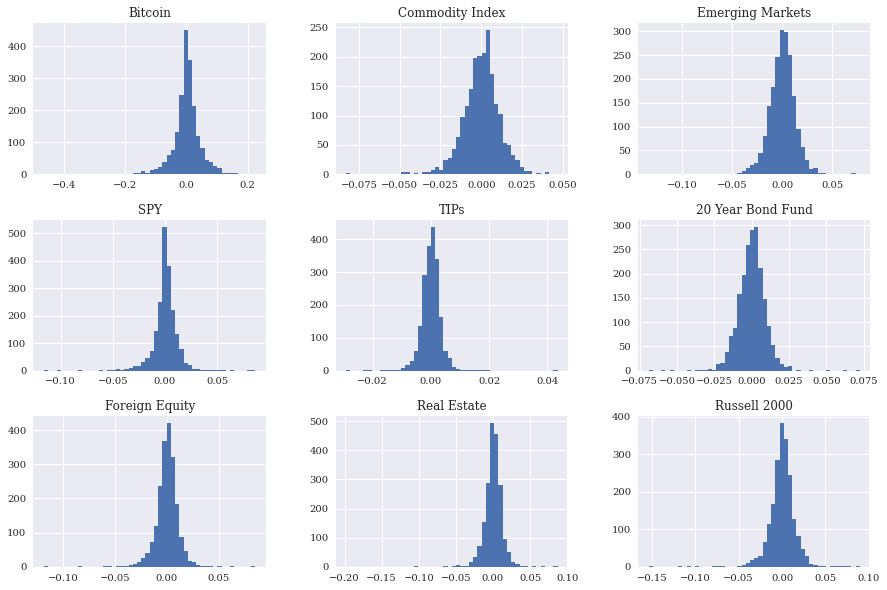

In [4]:
log_returns = np.log(adj_close/adj_close.shift(1))
log_returns.dropna(inplace = True)
log_returns.hist(bins = 50, figsize = (15,10))
noa = 9

<AxesSubplot:xlabel='Date'>

<Figure size 1080x720 with 0 Axes>

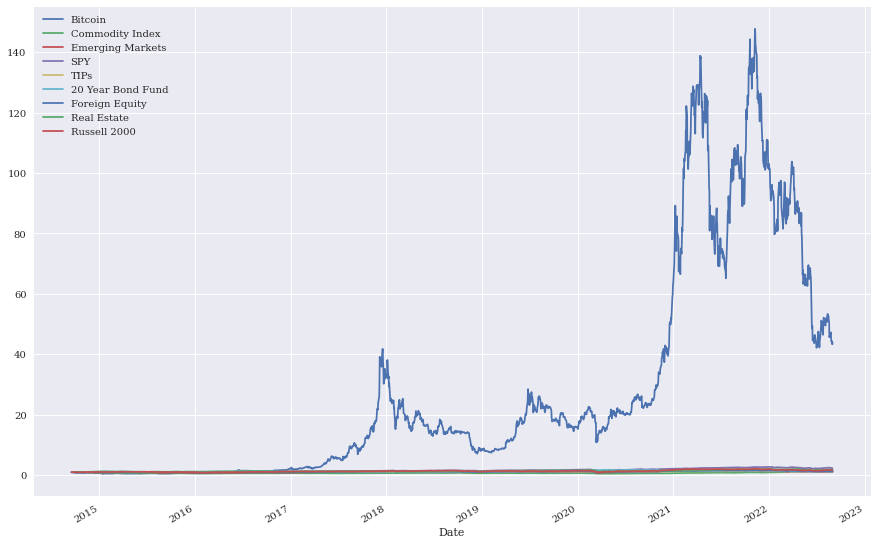

In [5]:
plt.figure(figsize = (15,10))
log_returns.cumsum().apply(np.exp).plot(figsize = (15,10))


In [6]:
log_returns.mean()*252


Bitcoin              0.475637
Commodity Index      0.012436
Emerging Markets     0.008344
SPY                  0.103808
TIPs                 0.025323
20 Year Bond Fund    0.020980
Foreign Equity       0.027589
Real Estate          0.067581
Russell 2000         0.058988
dtype: float64

In [7]:
log_returns.cov()*252

,Bitcoin,Commodity Index,Emerging Markets,SPY,TIPs,20 Year Bond Fund,Foreign Equity,Real Estate,Russell 2000
Bitcoin,0.539198,0.010000,0.027852,0.027207,0.002036,-0.003486,0.026981,0.022895,0.036234
Commodity Index,0.010000,0.033705,0.016011,0.012131,0.001429,-0.005733,0.013649,0.009463,0.015642
Emerging Markets,0.027852,0.016011,0.046992,0.030668,0.000106,-0.007770,0.033253,0.026162,0.036294
SPY,0.027207,0.012131,0.030668,0.033250,-0.000470,-0.008544,0.028588,0.029038,0.037334
TIPs,0.002036,0.001429,0.000106,-0.000470,0.003144,0.005687,0.000033,0.001393,-0.000283
20 Year Bond Fund,-0.003486,-0.005733,-0.007770,-0.008544,0.005687,0.021159,-0.008106,-0.003294,-0.010554
Foreign Equity,0.026981,0.013649,0.033253,0.028588,0.000033,-0.008106,0.031977,0.025761,0.033964
Real Estate,0.022895,0.009463,0.026162,0.029038,0.001393,-0.003294,0.025761,0.045350,0.035743
Russell 2000,0.036234,0.015642,0.036294,0.037334,-0.000283,-0.010554,0.033964,0.035743,0.054225


## Generating Risk-Return Profiles for a given set of financial instruments, and their statistical characteristics

- The goal of this is to implement a Monte Carlo simulation to generate random portfolio weight vectors on a larger scale. 
- For *every simulated allocation*, the code records the resulting expected portfolio return and variance.
- Here I define two functions:
        **port_ret()** and **port_vol**

In [8]:
weights = np.random.random(noa)
weights /= np.sum(weights)


In [9]:
def port_ret(weights):
    return np.sum(log_returns.mean() *weights)*252
def port_vol(weights):
    return np.sqrt(np.dot(weights.T,np.dot(log_returns.cov()*252, weights)))
prets = []
pvols = []
for p in range(5000):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)


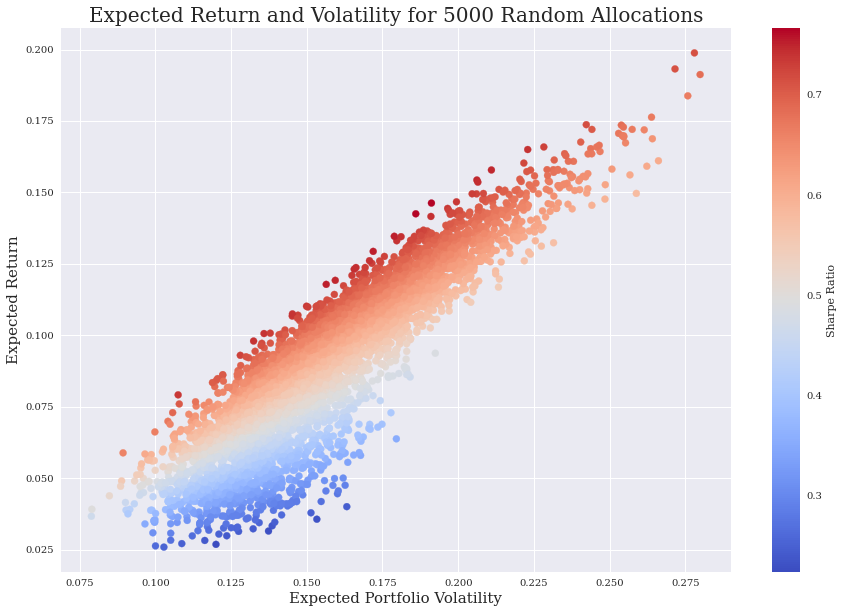

In [10]:
from scipy.ndimage import label


plt.figure(figsize = (15,10))
plt.scatter(pvols, prets, c = prets/pvols,marker = 'o', cmap = "coolwarm")
plt.xlabel("Expected Portfolio Volatility", fontsize = 15)
plt.ylabel("Expected Return", fontsize = 15)
plt.title("Expected Return and Volatility for 5000 Random Allocations", size = 20)
plt.colorbar(label = "Sharpe Ratio")
plt.show()

-It is clear from the picture above that not all weight distributions perform well when measured in terms of mean an volatility. For every fixed level risk, we can see their are multiple portfolios that show different returns. 
- As an investor one is generally interested in the maximum return given a fixed level of risk or the *minimum risk given a fixed return expectation*. 
- This set of portfolios then makes up the so-called **efficient frontier.**

## Optimal Portfolios

-The **minimization** function is general and allows for equality constraints, inequality constraints, and numerical bounds for the parameters. 
-The **maximization of the Sharpe ratio.** Formally, the negative value of the Sharpe ratio is minimized to derive at the maximum value and the optimal portfolio composition. The constraint is that all parameters (weights) add up to 1. This can be formulated using the conventions of the **minimize()** function.The parameters values (weights) are also bound to be between 0 and 1. These values are povided to the minimization function as a tuple of tuples. 

In [11]:
import scipy.optimize as sco

def min_func_sharpe(weights):
    return -port_ret(weights)/port_vol(weights)
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(noa))
eweights = np.array(noa*[1./noa,])
eweights
min_func_sharpe(eweights)

-0.5961963755608003

-Calling the function returns more than just optimal parameter values. THe results are stored in an object called **opts.** 
-The main interest lies in getttin gthe optimmal portfolio composition. 


In [12]:
opts = sco.minimize(min_func_sharpe, eweights, method = "SLSQP", constraints = cons)
pd.DataFrame(opts['x'].round(3), index = ["Bitcoin", "Commodity", "Emerging Markets", "SPY","TIPs", "20 Year Bonds", "Foreign Equity", "Real Estate", "Russell 2000"], columns = ["Weights"])

,Weights
Bitcoin,0.058
Commodity,-0.037
Emerging Markets,-0.177
SPY,1.100
TIPs,1.003
20 Year Bonds,-0.140
Foreign Equity,-0.444
Real Estate,-0.090
Russell 2000,-0.273


In [13]:
print("The resulting portfolio return and portfolio volatility from the optimal weights are", np.round(port_ret(opts['x']),4), "and",np.round(port_vol(opts["x"]),4), "respectively.")

The resulting portfolio return and portfolio volatility from the optimal weights are 0.1277 and 0.096 respectively.


- Next, the **Minimization of the Variance of the Portfolio.**This is the same as minimizing the volatility. 

In [14]:
optv = sco.minimize(port_vol, eweights, method = "SLSQP", bounds = bnds, constraints = cons)
pd.DataFrame(optv['x'].round(3), index = [ "Bitcoin", "Commodity", "Emerging Markets", "SPY","TIPs", "20 Year Bonds", "Foreign Equity", "Real Estate", "Russell 2000"], columns = ["Weights"])


,Weights
Bitcoin,0.000
Commodity,0.012
Emerging Markets,0.000
SPY,0.092
TIPs,0.896
20 Year Bonds,0.000
Foreign Equity,0.000
Real Estate,0.000
Russell 2000,0.000


In [15]:
print("Expected return", port_ret(optv['x']),"and minimizing portfolio volatility is", port_vol(optv['x']))

Expected return 0.03235898979122346 and minimizing portfolio volatility is 0.05282586013743122


## Efficient Frontier
- The derivation of all optimal portolios-i.e., all portfolios with minimum volatility for a given target return level (or all portfolios with maximum return for a given risk level) is similar to the previous optimizations. 
- The only difference is that one has to iterate over multipel starting conditions. 
- The approach is taken to fix a target retrn level and to derive for each level those portfolio weights that lead to the minimum volatility level. This leads to two conditions:
    one for the target return level, **tret**, and one for the sum of portfolio weights as before. The boundary levels for each parameter stay the same. When iterating over different target return levels (**trets**), one condition for the minimixation changes. 

-That is why the constraints dictionary is updated during every loop. 

In [28]:
cons = ({'type':'eq', 'fun': lambda x: port_ret(x)-tret}, {'type':'eq', 'fun': lambda x: np.sum(x)-1})
bnds = tuple((0,1)for x in weights)
trets = np.linspace(.02,.2,50)
tvols = []
for tret in trets:
    cons = ({'type':'eq', 'fun': lambda x: port_ret(x)-tret}, {'type':'eq', 'fun': lambda x: np.sum(x)-1})
    tvols.append(res['fun'])
tvols = np.array(tvols)

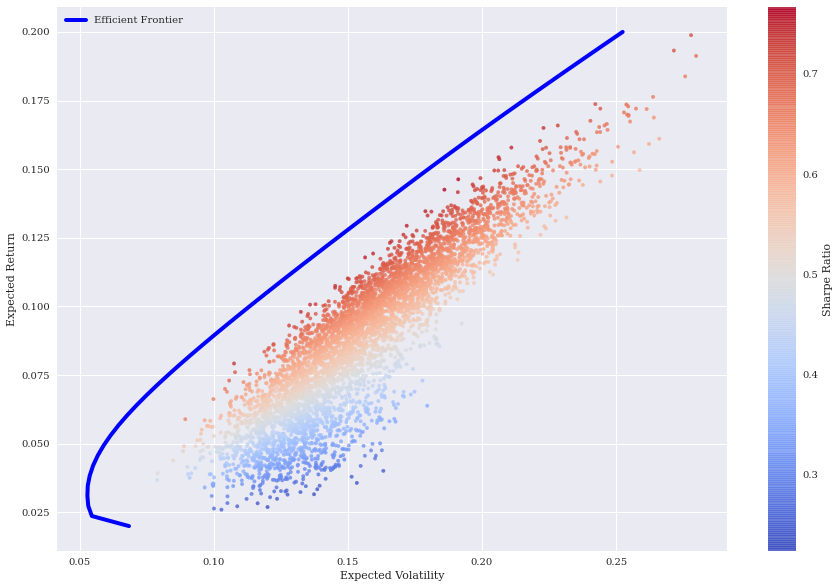

In [32]:
plt.figure(figsize = (15,10))
plt.scatter(pvols, prets, c = prets/pvols, marker = '.', alpha = 0.8, cmap = 'coolwarm')
plt.plot(tvols, trets, 'b',label = "Efficient Frontier",lw =4.0)
plt.xlabel("Expected Volatility")
plt.ylabel("Expected Return")
plt.legend(loc = "upper left")
plt.colorbar(label = "Sharpe Ratio")

## Captital Market Line

Taking into account a riskless assset enhances the effiecient investment opportunity set because investors first determine the efficient portfolio of risky assets and then add the riskless asset to th emix. Buy adjusting the proportion of the investor's wealth to be invested in the riskless asset, it is possible to achieve any risk -return profile that lies on the straight lie between the riskless asset and the efficient portfolio. 
In this model will will assume the risk-free rate is almost about zero.

In [35]:
import scipy.interpolate as sci
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]
tck = sci.splrep(evols, erets)

def f(x):
    return sci.splev(x, tck, der = 0)
def df(x):
    #First derivative of efficient frontier
    return sci.splev(x,tck, der = 1)

In [38]:
def equations(p, rf = 0.01):
    eq1 = rf - p[0]
    eq2 = rf +p[1]*p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3
opt = sco.fsolve(equations, [.01,.5,.15])   

np.round(equations(opt), 6)

array([0., 0., 0.])

Text(0, 0.5, 'Expected Return')

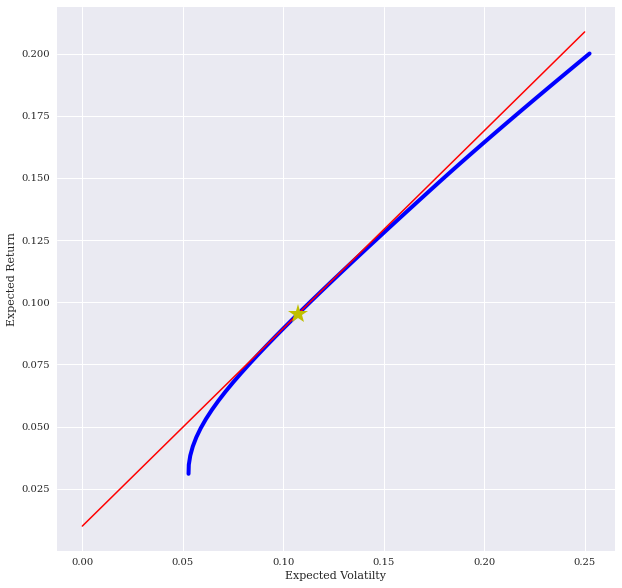

In [43]:
plt.figure(figsize = (10,10))
plt.plot(evols, erets, 'b', lw=4, label = "Efficient Frontier")
cx = np.linspace(0,.250)
plt.plot(cx, opt[0]+opt[1]*cx, 'r', lw =1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize = 20.0)
plt.grid(True)
plt.xlabel("Expected Volatilty")
plt.ylabel("Expected Return")

In [46]:
cons = ({'type':'eq', 'fun': lambda x: port_ret(x)-f(opt[2])}, {'type':'eq', 'fun': lambda x: np.sum(x)-1})
res = sco.minimize(port_vol, eweights, method = "SLSQP", bounds = bnds, constraints = cons)

pd.DataFrame(res['x'].round(3), index = [ "Bitcoin", "Commodity", "Emerging Markets", "SPY","TIPs", "20 Year Bonds", "Foreign Equity", "Real Estate", "Russell 2000"], columns = ["Weights"])

,Weights
Bitcoin,0.099
Commodity,0.000
Emerging Markets,0.000
SPY,0.331
TIPs,0.482
20 Year Bonds,0.088
Foreign Equity,0.000
Real Estate,0.000
Russell 2000,0.000


In [50]:
pd.DataFrame([port_ret(res['x']).round(4), port_vol(res['x']).round(4)], index = ["Portfolio Return", "Portfolio Volatility"])

,0
Portfolio Return,0.0954
Portfolio Volatility,0.1074
